In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from numpy import diag, dot
from numpy.linalg import pinv

The Least Squares (Monte Carlo) Solution
$$
v_{\pi} = (I - P_{\pi} \Gamma)^{-1} r_{\pi}
$$

$$
\Phi \theta \approx v_{\pi} 
$$

$$
\theta_{LS} = (\Phi^{\top} D_{\pi} \Phi)^{-1} \Phi^{\top} D_{\pi} v_{\pi}
$$


The ETD Solution:

$$
\theta_{ETD} = 
\left(
    \Phi^{\top} M 
    (I - P_{\pi} \Lambda \Gamma )^{-1} 
    (I - P_{\pi} \Gamma ) 
    \Phi 
\right)^{-1} 
\Phi^{\top} M 
(I - P_{\pi} \Gamma \Lambda)^{-1} r_{\pi}
$$

The TD Solution

$$
\theta_{TD} = (\Phi^{\top} D_{\pi} (I - P_{\pi} G) \Phi)^{-1} \Phi^{\top} D_{\pi} r_{\pi}
$$

In [3]:
def normalize(array, axis=None):
    """Normalize an array along an axis."""
    def _normalize(vec):
        return vec/np.sum(vec)
    if axis:
        return np.apply_along_axis(_normalize, axis, array)
    else:
        return _normalize(array)

def stationary(mat):
    """Compute the stationary distribution for transition matrix `mat`, via 
    c omputing the solution to the system of equations (P.T - I)*\pi = 0. 
        
    NB: Assumes `mat` is ergodic (aperiodic and irreducible).
    Could do with LU factorization -- c.f. 54-14 in Handbook of Linear Algebra
    """
    P = (np.copy(mat).T - np.eye(len(mat)))
    P[-1,:] = 1
    b = np.zeros(len(mat))
    b[-1] = 1
    x = np.linalg.solve(P, b)
    return normalize(x)

In [18]:
# Number of states
ns = 8

# Identity matrix
I = np.eye(ns)

# Define the transition matrix under the target policy
P = np.diag(np.ones(ns-1), 1)
P[-1,0] = 1
P_pi = P

# Calculate the stationary distribution under the target policy
d_pi = stationary(P).reshape(-1, 1)
D_pi = np.diag(d_pi.ravel())

# Define the expected reward under the target policy
rvec = np.zeros(ns)
rvec[-1] = 1

# Define the transition matrix under the behavior policy
P_mu = np.array([
        [0.0, 1, 0, 0, 0, 0, 0, 0],
        [0.0, 0, 1, 0, 0, 0, 0, 0],
        [0.0, 0, 0, 1, 0, 0, 0, 0],
        [0.0, 0, 0, 0, 1, 0, 0, 0],
        [0.5, 0, 0, 0, 0, 0.5, 0, 0],
        [0.5, 0, 0, 0, 0, 0, 0.5, 0],
        [0.5, 0, 0, 0, 0, 0, 0, 0.5],
        [1.0, 0, 0, 0, 0, 0, 0, 0],
], dtype=np.float)

# Calculate the stationary distribution under the behavior policy
d_mu = stationary(P_mu).reshape(-1, 1)

# Define the interest for each state
ivec = np.ones(ns)
imat = np.diag(ivec)

# Define the gamma matrix
gmvec = np.ones(ns) * 0.9
gmvec[0] = 0
G = np.diag(gmvec)

# Define the lambda matrix
lmvec = np.zeros(ns)
L = np.diag(lmvec)

# Define the feature matrix
X = np.eye(ns)

###############################################################
# Solve the emphasis equation
###############################################################
# Compute the "warp" matrix
P_lm = I - np.dot(pinv(I - np.dot(P, np.dot(G, L))), (I - np.dot(P, G)))

# Compute the emphasis distribution
d_i = np.dot(imat, d_mu)
mvec = np.dot(d_i.T, np.linalg.pinv(I - P_lm))
M = np.diag(mvec.ravel())

# Compute "A" matrix
A = X.T @ M @ (I - P_lm) @ X

# Compute "b" vector
b = X.T @ M @ pinv(I - P @ G @ L) @ rvec

# Solve the equation Aw = b
w_etd = pinv(A) @ b

###############################################################
# Solve for the TD solution
###############################################################
w_td = pinv(X.T @ D_pi @ (I - P_pi @ G) @ X) @ X.T @ D_pi @ rvec


###############################################################
# Solve for the least-squares solution
###############################################################
w_ls = pinv(X.T @ D_pi @ X) @ X.T @ D_pi @ pinv(I - P_pi @ G) @ rvec

In [7]:
np.dot(np.ones(3), np.ones(4))

ValueError: shapes (3,) and (4,) not aligned: 3 (dim 0) != 4 (dim 0)

In [19]:
w_etd

array([ 0.4782969,  0.531441 ,  0.59049  ,  0.6561   ,  0.729    ,
        0.81     ,  0.9      ,  1.       ])

In [20]:
w_td

array([ 0.4782969,  0.531441 ,  0.59049  ,  0.6561   ,  0.729    ,
        0.81     ,  0.9      ,  1.       ])

In [13]:
w_ls

array([ 0.4782969,  0.531441 ,  0.59049  ,  0.6561   ,  0.729    ,
        0.81     ,  0.9      ,  1.       ])

<Container object of 8 artists>

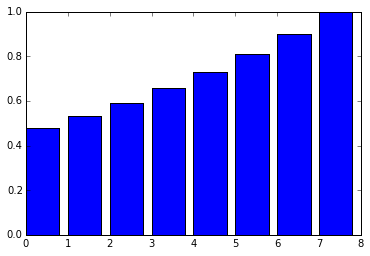

In [16]:
plt.bar(np.arange(ns), w_ls)

In [17]:
d_pi

array([[ 0.125],
       [ 0.125],
       [ 0.125],
       [ 0.125],
       [ 0.125],
       [ 0.125],
       [ 0.125],
       [ 0.125]])

In [26]:
X.T @ (I - P @ G) @ X

array([[ 1. , -0.9,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  1. , -0.9,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. , -0.9,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  1. , -0.9,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  1. , -0.9,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  1. , -0.9,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. , -0.9],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ]])